<h3>Research Question:</h3><p></p>

<p style="font-size: 24px">Data Cleaning</p>

In [1]:
import pandas as pd
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
felonies_nyc= pd.read_csv("felony.csv")
for column in felonies_nyc.columns[1:]:
    if felonies_nyc[column].dtype != int:
        felonies_nyc[column] = felonies_nyc[column].str.replace(",", "").astype(int)

felonies_nyc.head()


,OFFENSE,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,MURDER & NON-NEGL. MANSLAUGHTER,673,649,587,597,570,539,596,496,523,...,335,333,352,335,292,295,319,468,488,438
1,RAPE,2068,1981,2144,2070,1905,1858,1525,1351,1299,...,1378,1352,1438,1438,1449,1794,1755,1427,1491,1617
2,ROBBERY,32562,28202,27229,25989,24373,24722,23739,21809,22401,...,19128,16539,16931,15500,13956,12913,13371,13106,13831,17411
3,FELONY ASSAULT,25924,23453,21147,19139,18622,17750,17309,17493,16284,...,20297,20207,20270,20847,20052,20208,20698,20572,22835,26063
4,BURGLARY,38352,32763,31275,29110,26976,24117,23143,21762,20725,...,17429,16765,15125,12990,12083,11687,10783,15478,12811,15746


In [ ]:
#VISUALIZING CRIME AS A LINE GRAPH
nyc_crime= pd.read_csv('felonies_nyc')

  Geographic Area (in dollars)   1990   2000    2010    2013    2014    2015  \
0                        Bronx  15576  19965   29910   30647   31556   32778   
1             Brooklyn (Kings)  18333  25136   35811   39586   41399   43915   
2                    Manhattan  50225  88640  121550  145231  152690  155779   
3                       Queens  22397  28516   37259   39789   40997   43216   
4     Staten Island (Richmond)  23519  34676   43438   46219   48123   50894   

     2016    2017  
0   33310   35564  
1   45629   48758  
2  164056  175960  
3   44031   46829  
4   51836   54908  


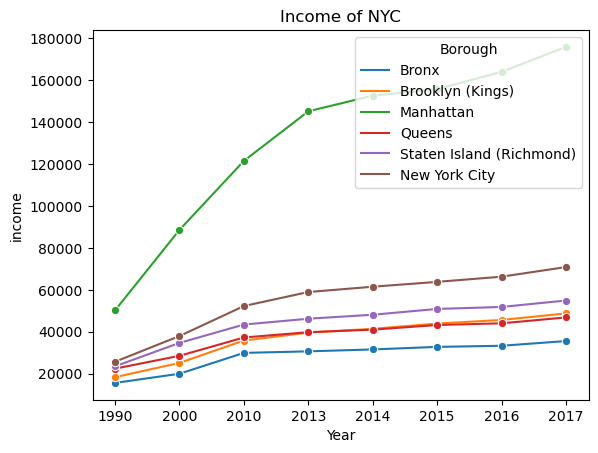

In [11]:
#VISUALIZING INCOME AS A LINE GRAPH

#Loading csv file
nyc_income= pd.read_csv('income.csv', encoding='latin1')
print(nyc_income.head())

#Melting the DataFrame
melted_demographic = nyc_income.melt(id_vars=['Geographic Area (in dollars)'], var_name='Year', value_name='Count')

#visualizong with a line plot
sns.lineplot(data=melted_demographic, x='Year', y='Count', hue='Geographic Area (in dollars)', marker='o')
plt.title("Income of NYC")
plt.xlabel("Year")
plt.ylabel("income")
plt.legend(title="Borough", loc='upper right')

   Year      White  NonHispanic      Black      Asian      Mixed   Hispanic
0  1990  3827088.0    3163125.0  2102512.0   512719.0   880245.0  1783511.0
1  2000  3576385.0    2801267.0  2129762.0   792477.0  1509654.0  2160554.0
2  2010  3597341.0    2722904.0  2088510.0  1043535.0  1445747.0  2336076.0
3  2020  3000945.0    2719856.0  1943645.0  1385144.0  2474456.0  2490350.0
   Year         Race      Count
0  1990        White  3827088.0
1  2000        White  3576385.0
2  2010        White  3597341.0
3  2020        White  3000945.0
4  1990  NonHispanic  3163125.0


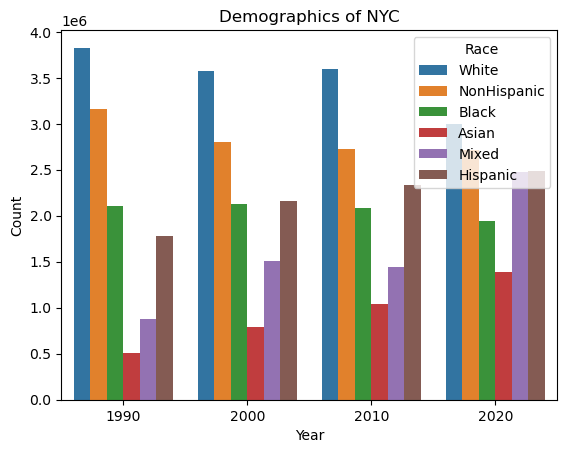

In [8]:
#reading in csv file
nyc_demographics= pd.read_csv('NYC_demographics.csv', encoding='latin1')

#changing year column values to int type so that they can be read as ints in further cleaning
nyc_demographics['Year']= nyc_demographics['Year'].astype(int)
#renaming column to prevent syntax issues 
nyc_demographics.rename(columns={'Non-Hispanic': 'NonHispanic'}, inplace=True)

#checking and changing column values that are originally objects and removing commas to facilitate float conversion later
for col in nyc_demographics:
    if nyc_demographics[col].dtype == 'object':
        nyc_demographics[col]= nyc_demographics[col].str.replace(",", "")

#changing the column value type from object to float
nyc_demographics[['White', 'NonHispanic', 'Black', 'Asian', 'Mixed',
                   'Hispanic',]]= nyc_demographics[['White', 'NonHispanic',
                    'Black', 'Asian', 'Mixed', 'Hispanic',]].astype(float)

#creating a clean dataframe that only has relevant columns
nyc_demographics_clean= db.sql("""
SELECT Year, White, NonHispanic, Black, Asian, Mixed, Hispanic
FROM nyc_demographics
WHERE Year > 1980""").df()
#confirming that new dataframe has correct information
print(nyc_demographics_clean)

#melting the dataframe and adding a column titled "Race" so that I can make a barplot that is colored by race
melted_demographic= pd.melt(nyc_demographics_clean, id_vars= 'Year', var_name= 'Race', value_name='Count')
print(melted_demographic.head())

#visualizing data with a barplot
sns.barplot(data= melted_demographic, x= 'Year', y='Count', hue='Race')
plt.title("Demographics of NYC")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Race", loc='upper right');

<p style="font-size: 20px;">Data Limitations</p>

<p>Some limitations we may approach when dealing with our data is the lack of dates (in years) for each dataset. For instance, we have crime data that spans from the year 2000 to 2020 and there are datapoints for every  year in between, meanwhile for demographic data we have usable data from the year 1990 to 2020, however there are only data points for each decade between that range. These limitations should not grossly affect any conclusions that we may come to make, but can possibly affect the intensity of our findings and the fit of our logistic regression model that we plan to produce in the future.</p>